In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
from utils import *
from Dataset.datasets import *
from Dataset.aggregation import *
from Dataset.metrics import *
from Optimization.clustering import *
from Optimization.portfolio_opt import *
from Evaluation.evaluate import *
from Evaluation.Plot_results import *
warnings.filterwarnings('ignore')

### Dates for training and evaluation

In [2]:
start_date_train = '2006-06-01'
end_date_train = '2016-01-01'

start_date_validation = '2016-01-01'
end_date_validation = '2024-01-23'

## Dataset preparation

In [3]:
df = download_stock_data(market_country ='US', 
                         start_date = '2006-01-01',)

[*********************100%%**********************]  503 of 503 completed


In [4]:
df.head()

adj close      close       high        low       open  \
date       ticker                                                          
2006-01-03 A       20.325130  23.962805  24.020029  23.476395  23.891273   
           AAL     35.305660  37.450001  38.279999  36.849998  37.200001   
           AAPL     2.263003   2.669643   2.669643   2.580357   2.585000   
           ABT     12.401362  18.976089  19.168011  18.803362  18.976089   
           ACGL     6.120000   6.120000   6.153333   6.097778   6.132222   

                        volume  
date       ticker               
2006-01-03 A         5307088.0  
           AAL       1013200.0  
           AAPL    807234400.0  
           ABT      17258233.0  
           ACGL      2712600.0

## Prepare the data

In [5]:
stock_measures = StockMeasures(df)
stock_measures.calculate_measures('all')
stock_measures.measures

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2006-01-03 A              -0.009833        NaN       NaN       NaN       NaN   
           AAL            -0.000330        NaN       NaN       NaN       NaN   
           AAPL           -0.006258        NaN       NaN       NaN       NaN   
           ABT            -0.069713        NaN       NaN       NaN       NaN   
           ACGL            0.000040        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2024-01-26 YUM             0.000105  50.708962  4.856013  4.872770  4.889527   
           ZBH             0.000045  56.739863  4.794179  4.811249  4.828319   
           ZBRA            0.000218  51.191561  5.479828  5.545973  5.612118   
           ZION            0.000160  57.948030  3.728311  3.786146  3.843982   
           ZTS             0.000153  52.795286  5.230000  5.267848  5.305696   

                        atr      macd  dollar_volume  
date       ticker                                     
2006-01-03 A            NaN       NaN     107.867256  
           AAL          NaN       NaN      35.771695  
           AAPL         NaN       NaN    1826.773573  
           ABT          NaN       NaN     214.025602  
           ACGL         NaN       NaN      16.601112  
...                     ...       ...            ...  
2024-01-26 YUM     0.705747  0.705747     149.357126  
           ZBH     0.007354  0.007354     119.596934  
           ZBRA    0.869534  0.869534      67.657211  
           ZION    0.522682  0.522682      66.245699  
           ZTS     1.024758  1.024758     352.435112  

[2131367 rows x 8 columns]

In [6]:
data_fit = stock_measures.measures.copy()
data_fit["adj close"] = df["adj close"]
data_fit.head()

garman_klass_vol  rsi  bb_low  bb_mid  bb_high  atr  macd  \
date       ticker                                                              
2006-01-03 A              -0.009833  NaN     NaN     NaN      NaN  NaN   NaN   
           AAL            -0.000330  NaN     NaN     NaN      NaN  NaN   NaN   
           AAPL           -0.006258  NaN     NaN     NaN      NaN  NaN   NaN   
           ABT            -0.069713  NaN     NaN     NaN      NaN  NaN   NaN   
           ACGL            0.000040  NaN     NaN     NaN      NaN  NaN   NaN   

                   dollar_volume  adj close  
date       ticker                            
2006-01-03 A          107.867256  20.325130  
           AAL         35.771695  35.305660  
           AAPL      1826.773573   2.263003  
           ABT        214.025602  12.401362  
           ACGL        16.601112   6.120000

In [7]:
data = aggregate_data_by_timestep(data_fit,
                                  timestep="M")
data

dollar_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                         
2006-02-28 A           93.422579         -0.011255  58.725570  3.063924   
           AAL         18.177839         -0.001315  50.802048  3.310012   
           AAPL      2061.015627         -0.015061  43.070909  1.080590   
           ABT        133.527120         -0.066818  64.058973  2.649104   
           ACGL        11.298589          0.000391  58.107168  1.918130   
...                          ...               ...        ...       ...   
2024-01-31 YUM        196.809561          0.000105  50.708962  4.856013   
           ZBH        204.029004          0.000045  56.739863  4.794179   
           ZBRA        99.053216          0.000218  51.191561  5.479828   
           ZION       109.331953          0.000160  57.948030  3.728311   
           ZTS        363.109587          0.000153  52.795286  5.230000   

                     bb_mid   bb_high       atr      macd   adj close  
date       ticker                                                      
2006-02-28 A       3.102648  3.141372 -0.760493 -0.760493   21.841930  
           AAL     3.425380  3.540748  0.771878  0.771878   31.195311  
           AAPL    1.135437  1.190284 -0.739157 -0.739157    2.073485  
           ABT     2.685074  2.721044 -0.773502 -0.773502   13.944457  
           ACGL    1.961811  2.005491 -0.801222 -0.801222    6.284444  
...                     ...       ...       ...       ...         ...  
2024-01-31 YUM     4.872770  4.889527  0.705747  0.705747  129.089996  
           ZBH     4.811249  4.828319  0.007354  0.007354  121.690002  
           ZBRA    5.545973  5.612118  0.869534  0.869534  252.169998  
           ZION    3.786146  3.843982  0.522682  0.522682   44.020000  
           ZTS     5.267848  5.305696  1.024758  1.024758  191.520004  

[101260 rows x 9 columns]

In [8]:
data = cut_low_volume(data, 
                      window = 5, 
                      min_years = 1, 
                      threshold = 150)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2007-01-31 A              -0.004250  39.746394  3.056571  3.104279  3.151988   
           AAL             0.003462  49.725083  3.904646  4.001428  4.098210   
           AAPL           -0.009099  47.520206  1.233249  1.305196  1.377144   
           ABT            -0.058135  69.853359  2.815995  2.873731  2.931467   
           ADBE            0.000241  46.364414  3.656179  3.699071  3.741963   
...                             ...        ...       ...       ...       ...   
2024-01-31 VRTX            0.000043  64.519320  6.005536  6.054672  6.103808   
           VZ              0.000040  70.186636  3.621979  3.697084  3.772190   
           WFC             0.000071  63.682813  3.862753  3.907793  3.952834   
           WMT             0.000034  60.845739  5.058206  5.084690  5.111174   
           XOM             0.000132  55.632470  4.570105  4.613145  4.656185   

                        atr      macd   adj close  
date       ticker                                  
2007-01-31 A      -0.854297 -0.854297   20.605667  
           AAL     3.310921  3.310921   52.774670  
           AAPL   -0.747846 -0.747846    2.595414  
           ABT    -0.821897 -0.821897   17.166779  
           ADBE   -0.644279 -0.644279   38.869999  
...                     ...       ...         ...  
2024-01-31 VRTX    1.512236  1.512236  430.170013  
           VZ      0.351427  0.351427   42.400002  
           WFC    -0.152748 -0.152748   50.320000  
           WMT     0.595994  0.595994  164.270004  
           XOM     0.280337  0.280337  103.000000  

[30545 rows x 8 columns]

In [9]:
data = aggregate_returns(data, outlier_cutoff = 0.005,
                         lags = [1, 2, 3, 6, 9, 12])
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-01-31 AAPL           -0.004133  31.622812  1.536141  1.752603  1.969064   
           ABT            -0.045550  46.041127  2.945846  3.005567  3.065287   
           ADBE            0.000849  32.721685  3.518945  3.639363  3.759781   
           ADM            -0.051310  57.143152  3.330924  3.410455  3.489986   
           ADSK            0.000759  38.289625  3.682652  3.780189  3.877726   
...                             ...        ...       ...       ...       ...   
2024-01-31 VRTX            0.000043  64.519320  6.005536  6.054672  6.103808   
           VZ              0.000040  70.186636  3.621979  3.697084  3.772190   
           WFC             0.000071  63.682813  3.862753  3.907793  3.952834   
           WMT             0.000034  60.845739  5.058206  5.084690  5.111174   
           XOM             0.000132  55.632470  4.570105  4.613145  4.656185   

                        atr      macd   adj close  return_1m  return_2m  \
date       ticker                                                         
2008-01-31 AAPL   -0.583384 -0.583384    4.097929  -0.314608  -0.138119   
           ABT    -0.133482 -0.133482   18.625826   0.005974  -0.008948   
           ADBE   -0.606921 -0.606921   34.930000  -0.182542  -0.089559   
           ADM     1.198207  1.198207   29.657898  -0.052768   0.099956   
           ADSK   -0.466215 -0.466215   41.150002  -0.173030  -0.065196   
...                     ...       ...         ...        ...        ...   
2024-01-31 VRTX    1.512236  1.512236  430.170013   0.057214   0.101088   
           VZ      0.351427  0.351427   42.400002   0.139913   0.060583   
           WFC    -0.152748 -0.152748   50.320000   0.022349   0.062311   
           WMT     0.595994  0.595994  164.270004   0.041992   0.029091   
           XOM     0.280337  0.280337  103.000000   0.030206   0.001265   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2008-01-31 AAPL    -0.106796   0.004503   0.034443    0.038795  
           ABT      0.011257   0.019226   0.001088    0.006821  
           ADBE    -0.099906  -0.023512  -0.019125   -0.008867  
           ADM      0.072333   0.047025   0.015410    0.027970  
           ADSK    -0.055895  -0.004858  -0.000323   -0.005036  
...                      ...        ...        ...         ...  
2024-01-31 VRTX     0.059091   0.033823   0.026237    0.024138  
           VZ       0.070656   0.043639   0.016077    0.007677  
           WFC      0.084792   0.017307   0.029339    0.008523  
           WMT      0.002990   0.005761   0.010665    0.012388  
           XOM     -0.006045  -0.003838  -0.012469   -0.007089  

[27739 rows x 14 columns]

In [10]:
betas = get_famafrench_factors(data)
betas

Mkt-RF       SMB       HML
date       ticker                              
2010-01-31 AAPL         NaN       NaN       NaN
           ABT          NaN       NaN       NaN
           ADBE         NaN       NaN       NaN
           ADM          NaN       NaN       NaN
           ADSK         NaN       NaN       NaN
...                     ...       ...       ...
2023-11-30 VRTX    0.386293 -0.797340  0.047655
           VZ      0.463830 -0.737556  0.264843
           WFC     1.044033  1.059224  1.150321
           WMT     0.516778 -0.419738 -0.222054
           XOM     0.719891 -0.441182  1.245126

[24062 rows x 3 columns]

### Filter stocks with less than 10 month data

In [11]:
ff_factors = ['Mkt-RF', 'SMB', 'HML']

# we merge the previously dataset with the one that we have for the betas factors.

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, ff_factors] = data.groupby('ticker', group_keys=False)[ff_factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis = 1)

feature_data = data.dropna()

feature_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27295 entries, (Timestamp('2008-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-01-31 00:00:00'), 'XOM')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  27295 non-null  float64
 1   rsi               27295 non-null  float64
 2   bb_low            27295 non-null  float64
 3   bb_mid            27295 non-null  float64
 4   bb_high           27295 non-null  float64
 5   atr               27295 non-null  float64
 6   macd              27295 non-null  float64
 7   return_1m         27295 non-null  float64
 8   return_2m         27295 non-null  float64
 9   return_3m         27295 non-null  float64
 10  return_6m         27295 non-null  float64
 11  return_9m         27295 non-null  float64
 12  return_12m        27295 non-null  float64
 13  Mkt-RF            27295 non-null  float64
 14  SMB               27295 non-null  float64
 15  HML       

## Training validation split

In [12]:
data_train = feature_data.loc[(slice(start_date_train, end_date_train), slice(None)), :]

data_validation = feature_data.loc[(slice(start_date_validation, None), slice(None)), :]

In [13]:
best_rsi_data_M_km_train = data_train.copy().dropna().groupby('date', 
                                                              group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_train = list_monthly_stocks(best_rsi_data_M_km_train)

In [14]:
best_rsi_data_M_db_train = data_train.copy().dropna().groupby('date',
                                                              group_keys = False).apply(lambda df: dbscan_best_rsi(df))
chosen_stocks_db_train = list_monthly_stocks(best_rsi_data_M_db_train)

In [27]:
chosen_stocks_noclust = list_monthly_stocks(data_train.dropna())

In [28]:
all_stocks = list(np.unique([s for stocks_list in chosen_stocks_noclust.values() for s in stocks_list]))
stocks = list(np.unique([s for stocks_list in chosen_stocks_km_train.values() for s in stocks_list]))
stocks_db = list(np.unique([s for stocks_list in chosen_stocks_db_train.values() for s in stocks_list]))

start_date = data_train.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = data_train.index.get_level_values('date').unique()[-1]

new_df_noclust_train = yf.download(tickers = all_stocks, start = start_date, end = end_date)
new_df_k_means_train = yf.download(tickers = stocks, start = start_date, end = end_date)
new_df_db_train = yf.download(tickers = stocks_db, start = start_date, end = end_date)

[*********************100%%**********************]  170 of 170 completed
[*********************100%%**********************]  168 of 168 completed
[*********************100%%**********************]  34 of 34 completed


We need then to calculate all the daily returns for each stocks form the data we have downloaded.

Then for each month we select the stocks of the month and calculate the weights for the next month.

If the maximum sharpe ratio fails to assign the weights for a given month, we apply equally weighted weights.

Then we calculate for each day the porfolio return.

### Training

In [29]:
p_train_results_no = []
p_train_results_km = []
p_train_results_db = []

In [30]:
# Base strategy
p_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         stop_loss = False)

p_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = False)

p_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = False)

p_train_results_no.append(p_train)
p_train_results_km.append(p_km_train)
p_train_results_db.append(p_db_train)

In [ ]:
# Persistency strategy
p_ps_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         stop_loss= False,
                                         mode = "Persistency")

p_ps_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = False,
                                    mode = "Persistency")

p_ps_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = False,
                                    mode = "Persistency")

p_train_results_no.append(p_ps_train)
p_train_results_km.append(p_ps_km_train)
p_train_results_db.append(p_ps_db_train)

In [ ]:
# Regression
p_reg_train = daily_portfolio_return(chosen_stocks_noclust, 
                                         new_df_noclust_train,
                                         off_set_days = 30,
                                         stop_loss = True)

p_km_reg_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_db_reg_train = daily_portfolio_return(chosen_stocks_db_train,
                                                    new_df_db_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_train_results_no.append(p_reg_train)
p_train_results_km.append(p_km_reg_train)
p_train_results_db.append(p_db_reg_train)

Number of times the filter has been used:  23
Number of times the filter has been used:  13
Number of times the filter has been used:  19


In [ ]:
plot_arima = False

if plot_arima:
    p_ARIMA_train = daily_portfolio_return(chosen_stocks_noclust, 
                                            new_df_noclust_train,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_km_ARIMA_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True, 
                                                    mode = 'Arima',
                                                    order = (6,2,1))

    p_db_ARIMA_train = daily_portfolio_return(chosen_stocks_db_train,
                                            new_df_db_train, 
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_train_results_no.append(p_ARIMA_train)
    p_train_results_km.append(p_km_ARIMA_train)
    p_train_results_db.append(p_db_ARIMA_train)

In [ ]:
samples = 50
confidence_level = .97

baselines_train = {
    "no": get_random_baseline(chosen_stocks_noclust, new_df_noclust_train, samples, confidence_level),
    "km": get_random_baseline(chosen_stocks_km_train, new_df_k_means_train, samples, confidence_level),
    "db": get_random_baseline(chosen_stocks_db_train, new_df_db_train, samples, confidence_level)
}

Number of times the filter has been used:  2400
Number of times the filter has been used:  2341
Number of times the filter has been used:  2365


In [ ]:
spy = yf.download(tickers='SPY',
                  start=list(chosen_stocks_db_train.keys())[0],
                  end=end_date_train)


spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

refering_index = {
    "name" : 'S&P 500',
    "return" : spy_ret
}

result_training_no = pd.concat(p_train_results_no, axis=1)
result_training_km = pd.concat(p_train_results_km, axis=1)
result_training_db = pd.concat(p_train_results_db, axis=1)

strat_names = ['Base Strategy', 'Persistency', 'Regression']
if plot_arima: 
    strat_names += ['Arima']

result_training_no.columns = strat_names
result_training_km.columns = strat_names
result_training_db.columns = strat_names

[*********************100%%**********************]  1 of 1 completed


In [23]:
plot_portfolio_cumulative_return(result_training_no, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["no"],
                                 title= "Trading Strategy Returns over time Without Clustering",
                                 save_path= "./Results/Images/US_noclust_train")

plot_portfolio_cumulative_return(result_training_km, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["km"],
                                 title= "Trading Strategy Returns over time with K-Means Clustering",
                                 save_path= "./Results/Images/US_kmeans_train")

plot_portfolio_cumulative_return(result_training_db, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_train["db"],
                                 title= "Trading Strategy Returns over time with DBScan Clustering",
                                 save_path= "./Results/Images/US_dbscan_train")


NameError: name 'result_training_no' is not defined

In [ ]:
volatility_no = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_no]
sharpe_ratio_no = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_no]
cumulative_return_no = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_no]

volatility_km = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_km]
sharpe_ratio_km = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_km]
cumulative_return_km = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_km]

volatility_db = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_train_results_db]
sharpe_ratio_db = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_train_results_db]
cumulative_return_db = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_train_results_db]

results_training = np.array([
    volatility_no,
    sharpe_ratio_no,
    cumulative_return_no,
    volatility_km,
    sharpe_ratio_km,
    cumulative_return_km,
    volatility_db,
    sharpe_ratio_db,
    cumulative_return_db,
])

index = pd.MultiIndex.from_product([["No-Clust", "K-Means", "DBSCAN"], ["Volatility", "Sharpe Ratio", "Cumulative Return"]], names= ["Clustering", "Measure"])

results_training_df = pd.DataFrame(results_training, index= index, columns= strat_names)
results_training_df

### Validation

In [ ]:
best_rsi_data_M_km_val = data_validation.copy().dropna().groupby('date', 
                                                             group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_val = list_monthly_stocks(best_rsi_data_M_km_val)

In [ ]:
best_rsi_data_M_db_val =data_validation.copy().dropna().groupby('date',
                                                                group_keys = False).apply(lambda df: dbscan_best_rsi(df))
chosen_stocks_db_val = list_monthly_stocks(best_rsi_data_M_db_val)

In [ ]:
chosen_stocks_noclust_val = list_monthly_stocks(data_validation.dropna())

In [ ]:
all_stocks = list(np.unique([s for stocks_list in chosen_stocks_noclust_val.values() for s in stocks_list]))
stocks_km_val = list(np.unique([s for stocks_list in chosen_stocks_km_val.values() for s in stocks_list]))
stocks_db_val = list(np.unique([s for stocks_list in chosen_stocks_db_val.values() for s in stocks_list]))

start_date_val = data_validation.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date_val = data_validation.index.get_level_values('date').unique()[-1]

new_df_noclust_val = yf.download(tickers = all_stocks, 
                                 start = start_date_val, 
                                 end = end_date_val)

new_df_k_means_val = yf.download(tickers = stocks_km_val,
                             start = start_date_val, 
                             end = end_date_val)


new_df_db_val = yf.download(tickers = stocks_db_val,
                        start = start_date_val, 
                        end = end_date_val)

[*********************100%%**********************]  503 of 503 completed
[*********************100%%**********************]  183 of 183 completed
[*********************100%%**********************]  41 of 41 completed


In [ ]:
p_val_results_no = []
p_val_results_km = []
p_val_results_db = []

In [ ]:
p_val = daily_portfolio_return(chosen_stocks_noclust_val,
                                         new_df_noclust_val, 
                                         stop_loss = False)

p_km_val = daily_portfolio_return(chosen_stocks_km_val,
                                         new_df_k_means_val, 
                                         stop_loss = False)

p_db_val = daily_portfolio_return(chosen_stocks_db_val,
                                         new_df_db_val, 
                                         stop_loss = False)

p_val_results_no.append(p_val)
p_val_results_km.append(p_km_val)
p_val_results_db.append(p_db_val)

In [ ]:
p_ps_val = daily_portfolio_return(chosen_stocks_noclust_val, 
                                         new_df_noclust_val,
                                         stop_loss= True,
                                        mode= "Persistency")

p_km_ps_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      stop_loss= True,
                                      mode= "Persistency")

p_db_ps_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      stop_loss = True,
                                        mode= "Persistency")

p_val_results_no.append(p_ps_val)
p_val_results_km.append(p_km_ps_val)
p_val_results_db.append(p_db_ps_val)

'return'
Number of times the filter has been used:  41
'return'
Number of times the filter has been used:  35
'return'
Number of times the filter has been used:  38


In [ ]:
p_reg_val = daily_portfolio_return(chosen_stocks_noclust_val, 
                                         new_df_noclust_val,
                                         off_set_days= 30,
                                         stop_loss= True)

p_km_reg_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      off_set_days = 30, 
                                      stop_loss = True)

p_db_reg_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      off_set_days = 30,
                                      stop_loss = True)

p_val_results_no.append(p_reg_val)
p_val_results_km.append(p_km_reg_val)
p_val_results_db.append(p_db_reg_val)

Number of times the filter has been used:  25
Number of times the filter has been used:  9
Number of times the filter has been used:  24


In [ ]:
if plot_arima:
    p_ARIMA_val = daily_portfolio_return(chosen_stocks_noclust_val,
                                            new_df_noclust_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_km_ARIMA_val = daily_portfolio_return(chosen_stocks_km_val,
                                            new_df_k_means_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_db_ARIMA_val = daily_portfolio_return(chosen_stocks_db_val,
                                            new_df_db_val,
                                            off_set_days = 30,
                                            stop_loss = True,
                                            mode = 'Arima',
                                            order = (6,2,1))

    p_val_results_no.append(p_ARIMA_val)
    p_val_results_km.append(p_km_ARIMA_val)
    p_val_results_db.append(p_db_ARIMA_val)

In [ ]:
samples = 50
confidence_level = .97

baselines_val = {
    "no": get_random_baseline(chosen_stocks_noclust_val, new_df_noclust_val, samples, confidence_level),
    "km": get_random_baseline(chosen_stocks_km_val, new_df_k_means_val, samples, confidence_level),
    "db": get_random_baseline(chosen_stocks_db_val, new_df_db_val, samples, confidence_level)
}

Number of times the filter has been used:  2417
Number of times the filter has been used:  2394
Number of times the filter has been used:  2476


In [ ]:
spy = yf.download(tickers='SPY',
                  start = start_date_validation,
                  end = end_date_validation)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

refering_index = {
    "name" : 'S&P 500',
    "return" : spy_ret
}

result_validation_no = pd.concat(p_val_results_no, axis=1)
result_validation_km = pd.concat(p_val_results_km, axis=1)
result_validation_db = pd.concat(p_val_results_db, axis=1)

strat_names = ['Base Strategy', 'Persistency', 'Regression']
if plot_arima: 
    strat_names += ['Arima']

result_validation_no.columns = strat_names
result_validation_km.columns = strat_names
result_validation_db.columns = strat_names

[*********************100%%**********************]  1 of 1 completed


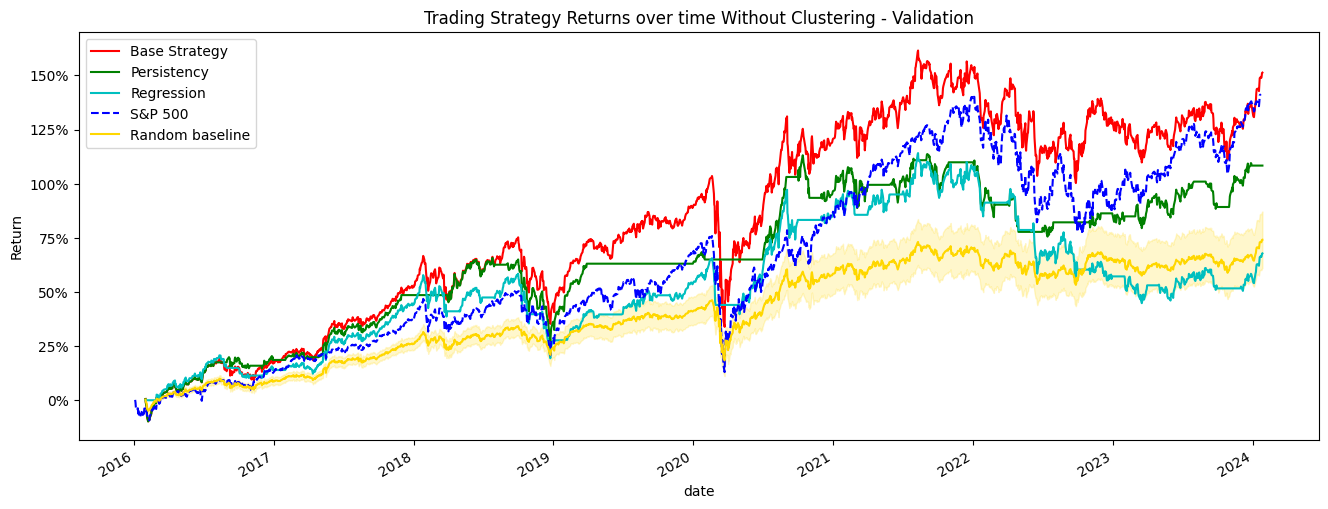

Results obtained using Base Strategy: 
Volatility   :  0.01483
Sharpe ratio :  0.02434

Results obtained using Persistency: 
Volatility   :  0.01483
Sharpe ratio :  0.02434

Results obtained using Regression: 
Volatility   :  0.01038
Sharpe ratio :  0.03365



In [ ]:
plot_portfolio_cumulative_return(result_validation_no, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["no"],
                                 title= "Trading Strategy Returns over time Without Clustering - Validation",
                                 save_path= "./Results/Images/IT_noclust_val.png")

plot_portfolio_cumulative_return(result_validation_km, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["km"],
                                 title= "Trading Strategy Returns over time with K-Means Clustering - Validation",
                                 save_path= "./Results/Images/IT_kmeans_val.png")

plot_portfolio_cumulative_return(result_validation_db, 
                                 refering_index= refering_index,
                                 random_returns_df= baselines_val["db"],
                                 title= "Trading Strategy Returns over time with DBScan Clustering - Validation",
                                 save_path= "./Results/Images/IT_dbscan_val.png")


In [ ]:
volatility_no = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_no]
sharpe_ratio_no = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_no]
cumulative_return_no = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_no]

volatility_km = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_km]
sharpe_ratio_km = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_km]
cumulative_return_km = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_km]

volatility_db = [np.round(float(calculate_volatility(return_strategy)),5) for return_strategy in p_val_results_db]
sharpe_ratio_db = [np.round(float(calculate_sharpe_ratio(return_strategy)),5) for return_strategy in p_val_results_db]
cumulative_return_db = [np.round(float(calculate_cumulative_return(return_strategy)),5) for return_strategy in p_val_results_db]

results_validation = np.array([
    volatility_no,
    sharpe_ratio_no,
    cumulative_return_no,
    volatility_km,
    sharpe_ratio_km,
    cumulative_return_km,
    volatility_db,
    sharpe_ratio_db,
    cumulative_return_db,
])

index = pd.MultiIndex.from_product([["No-Clust", "K-Means", "DBSCAN"], ["Volatility", "Sharpe Ratio", "Cumulative Return"]], names= ["Clustering", "Measure"])

results_validation_df = pd.DataFrame(results_validation, index= index, columns= strat_names)
results_validation_df

#### Save results

In [ ]:
if not os.path.exists("./Results"):
    os.makedirs("./Results")
with pd.ExcelWriter("./Results/Italian_market.xlsx") as writer:
    results_training_df.to_excel(writer, sheet_name= "Training")
    results_validation_df.to_excel(writer, sheet_name= "Validation")